In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install ipython-autotime

%load_ext autotime

time: 373 µs (started: 2022-01-22 04:11:04 +00:00)


In [4]:
import fastai
from fastai.vision import *
from fastai.basics import *
#!pip install "torch==1.4" "torchvision==0.5.0"
from fastai.callbacks.hooks import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback
from fastai.imports import *
# import sys
# sys.path.append('../')
# from fastai.conv_learner import *


time: 6.91 s (started: 2022-01-22 04:13:29 +00:00)


In [5]:
fastai.__version__

'1.0.61'

time: 2.93 ms (started: 2022-01-22 04:13:36 +00:00)


### Data

In [6]:

# root_dir = '/content/drive/My Drive/histopathology/dataset/traintest/40x/2CLASS'
root_dir = '/content/drive/MyDrive/Dynamic_frontal'
path = Path(root_dir)
#path = "./drive/My Drive/phd/dataset/X-Ray Image Dataset"

time: 1.67 ms (started: 2022-01-22 04:13:40 +00:00)


In [7]:
ds_tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      #max_warp=0.,
                      #max_zoom=1.05,
                      #max_lighting=0.1,
                      p_lighting=0.5
                     )

time: 1.95 ms (started: 2022-01-22 04:13:44 +00:00)


In [48]:
# np.random.seed(41)

data = ImageDataBunch.from_folder(path, train="train",valid_pct=0.1,test='test',
                                  ds_tfms=get_transforms(), size=(256,256), bs=8, num_workers=4).normalize(imagenet_stats)


time: 262 ms (started: 2022-01-22 04:33:03 +00:00)


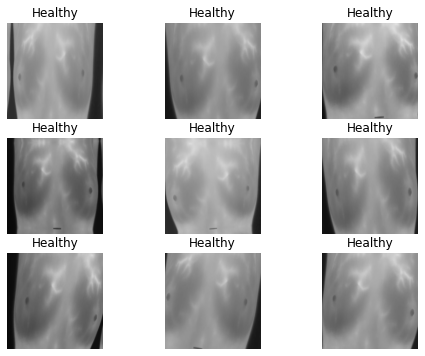

time: 693 ms (started: 2022-01-22 04:33:06 +00:00)


In [49]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

In [51]:
data

ImageDataBunch;

Train: LabelList (3331 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Healthy,Healthy,Healthy,Healthy,Healthy
Path: /content/drive/MyDrive/Dynamic_frontal;

Valid: LabelList (370 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Healthy,Sick,Healthy,Healthy,Sick
Path: /content/drive/MyDrive/Dynamic_frontal;

Test: LabelList (1586 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/Dynamic_frontal

time: 131 ms (started: 2022-01-22 04:33:40 +00:00)


In [52]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds) ,data.train_ds.classes

(['Healthy', 'Sick'], 2, 3331, 370, ['Healthy', 'Sick'])

time: 3.48 ms (started: 2022-01-22 04:33:52 +00:00)


In [53]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 3331
Number of examples in validation: 370
time: 3.05 ms (started: 2022-01-22 04:33:58 +00:00)


In [54]:
xp,yp = data.one_batch()
xp.shape,yp.shape
print(yp)

tensor([1, 1, 0, 0, 1, 1, 0, 0])
time: 99.8 ms (started: 2022-01-22 04:34:00 +00:00)


In [55]:
train_labels = data.train_ds.y
train_labels

CategoryList (3331 items)
Healthy,Healthy,Healthy,Healthy,Healthy
Path: /content/drive/MyDrive/Dynamic_frontal

time: 3.2 ms (started: 2022-01-22 04:34:04 +00:00)


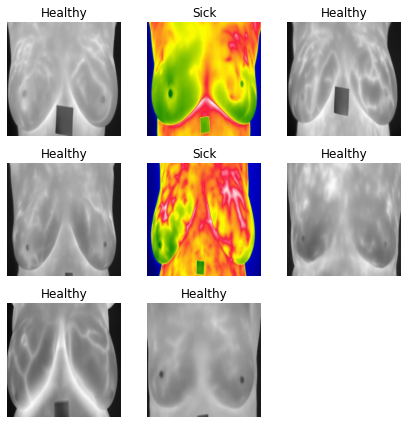

time: 572 ms (started: 2022-01-22 04:34:07 +00:00)


In [56]:
data.show_batch(rows=6, ds_type=DatasetType.Valid, figsize=(6,6))

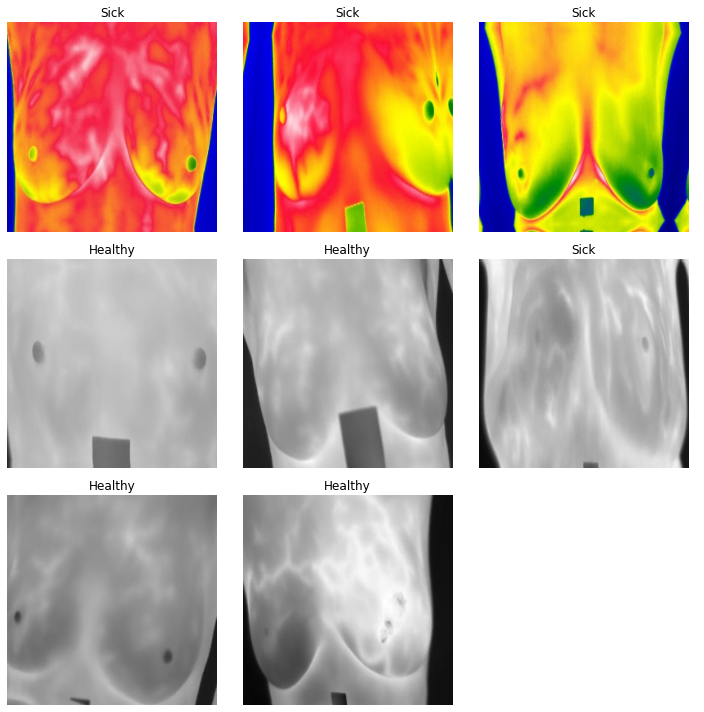

time: 1.48 s (started: 2022-01-22 04:34:11 +00:00)


In [57]:
#Sample images from the dataset
data.show_batch(rows=6, ds_type=DatasetType.Train, figsize=(10,10))

In [58]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Healthy', 'Sick']
time: 1.36 ms (started: 2022-01-22 04:34:17 +00:00)


## DarkCovidNet (modified Darknet model)

# New Section

In [59]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

time: 3.07 ms (started: 2022-01-22 04:34:20 +00:00)


In [60]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

time: 1.85 ms (started: 2022-01-22 04:34:24 +00:00)


In [61]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

time: 1.34 ms (started: 2022-01-22 04:34:27 +00:00)


In [62]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338,2)
)

time: 21.7 ms (started: 2022-01-22 04:34:30 +00:00)


In [63]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 

time: 3.84 ms (started: 2022-01-22 04:34:33 +00:00)


In [64]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy,
                #callback_fns=ShowGraph,
                callback_fns=ActivationStats)

time: 4.22 ms (started: 2022-01-22 04:34:40 +00:00)


In [65]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [66]:
#run 1 epoch with lower layers
learn.fit_one_cycle(150, max_lr=3e-3) 

epoch,train_loss,valid_loss,accuracy,time
0,0.279158,0.208510,0.924324,01:08
1,0.227146,0.150450,0.935135,01:08
2,0.186326,0.154674,0.927027,01:08
3,0.199504,0.132379,0.945946,01:08
4,0.176029,0.109290,0.964865,01:08
5,0.146101,0.113078,0.951351,01:08
6,0.191850,0.081257,0.967568,01:08
7,0.151539,0.073413,0.972973,01:09
8,0.153427,0.084147,0.970270,01:08
9,0.162918,0.093531,0.970270,01:08


time: 2h 53min 9s (started: 2022-01-22 04:34:51 +00:00)


In [67]:
learn.save('/content/drive/MyDrive/Dynamic_frontal/new')
#learn.save('/content/drive/My Drive/histopathology/model/less dataset model_DCN  alone/model_40x_V2')

time: 58.3 ms (started: 2022-01-22 07:28:00 +00:00)


In [68]:
learn.load('/content/drive/MyDrive/Static_frontal/new')
#learn.load('/content/drive/My Drive/histopathology/mymodel_100feature_40x')
#learn.load('/content/drive/My Drive/histopathology/model/less dataset model/model_DCN Alone_40x_V2')

Learner(data=ImageDataBunch;

Train: LabelList (3331 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Healthy,Healthy,Healthy,Healthy,Healthy
Path: /content/drive/MyDrive/Dynamic_frontal;

Valid: LabelList (370 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Healthy,Sick,Healthy,Healthy,Sick
Path: /content/drive/MyDrive/Dynamic_frontal;

Test: LabelList (1586 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/Dynamic_frontal, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): 

time: 723 ms (started: 2022-01-22 07:28:01 +00:00)


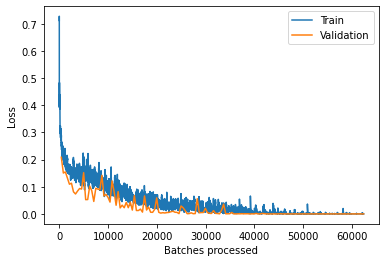

time: 407 ms (started: 2022-01-22 07:28:01 +00:00)


In [69]:
learn.recorder.plot_losses()

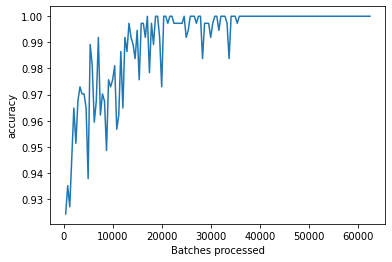

time: 166 ms (started: 2022-01-22 07:28:02 +00:00)


In [70]:
learn.recorder.plot_metrics()

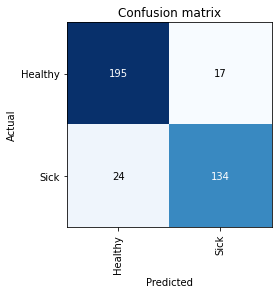

time: 2.36 s (started: 2022-01-22 07:28:02 +00:00)


In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

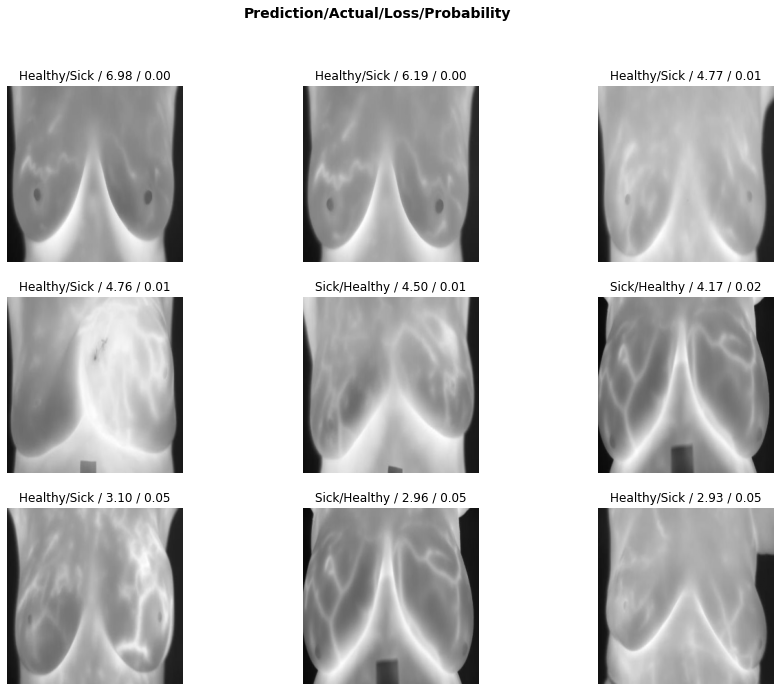

time: 673 ms (started: 2022-01-22 07:28:04 +00:00)


In [72]:

interp.plot_top_losses(9, figsize=(15,11))

In [73]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid)

time: 2.21 s (started: 2022-01-22 07:28:05 +00:00)


In [74]:
len(probs)

370

time: 3.14 ms (started: 2022-01-22 07:28:07 +00:00)


In [75]:
print(np.argmax(probs,axis=1))
print(targets)

tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,

In [ ]:
accuracy(np.argmax(probs,axis=1),targets)

TypeError: ignored

time: 16.9 ms (started: 2022-01-19 09:47:51 +00:00)


In [76]:
probs1 = np.argmax(probs, axis=0)
correct = 0
for idx, pred in enumerate(probs1):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs1)
print(len(probs1), correct, accuracy)



2 0 0.0
time: 3.63 ms (started: 2022-01-22 07:28:07 +00:00)


In [77]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, np.argmax(probs,axis=1))
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = np.argmax(probs,axis=1)
target_names = ['Healthy', 'Sick']
print(classification_report(y_true1, y_pred1, target_names=target_names))

[[195  17]
 [ 24 134]]
              precision    recall  f1-score   support

     Healthy       0.89      0.92      0.90       212
        Sick       0.89      0.85      0.87       158

    accuracy                           0.89       370
   macro avg       0.89      0.88      0.89       370
weighted avg       0.89      0.89      0.89       370

time: 219 ms (started: 2022-01-22 07:28:07 +00:00)


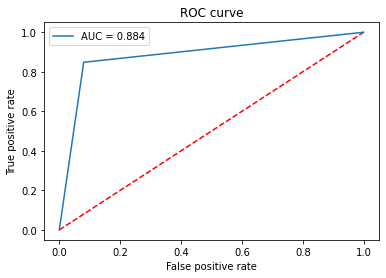

time: 153 ms (started: 2022-01-22 07:30:16 +00:00)


In [79]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(y_true1, y_pred1)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_true1, y_pred1)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

In [80]:
data.valid_ds

LabelList (370 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Healthy,Sick,Healthy,Healthy,Sick
Path: /content/drive/MyDrive/Dynamic_frontal

time: 51.7 ms (started: 2022-01-22 07:31:22 +00:00)


In [81]:
path1= '/content/drive/MyDrive/Dynamic_frontal'
# path1='/content/drive/My Drive/histopathology/dataset/less dataset'

time: 1.32 ms (started: 2022-01-22 07:32:10 +00:00)


In [82]:
data1= ImageDataBunch.from_folder(path1, train="train",valid='test',
                                   size=(256,256), bs=32, num_workers=4).normalize(imagenet_stats)

time: 411 ms (started: 2022-01-22 07:32:22 +00:00)


In [83]:
data1.valid_ds
train_labels = data1.valid_ds.y
train_labels


CategoryList (1586 items)
Healthy,Healthy,Healthy,Healthy,Healthy
Path: /content/drive/MyDrive/Dynamic_frontal

time: 3.41 ms (started: 2022-01-22 07:32:29 +00:00)


In [84]:
learn.data = data1

time: 1.1 ms (started: 2022-01-22 07:32:36 +00:00)


In [85]:
probs_1,targets_1 = learn.get_preds(ds_type=DatasetType.Valid)
testlabels = np.argmax(probs_1, 1)

time: 5.98 s (started: 2022-01-22 07:32:44 +00:00)


In [86]:
np.argmax(probs_1,axis=1)

tensor([0, 0, 0,  ..., 1, 1, 1])

time: 4.14 ms (started: 2022-01-22 07:32:58 +00:00)


In [87]:
targets_1

tensor([0, 0, 0,  ..., 1, 1, 1])

time: 2.92 ms (started: 2022-01-22 07:33:04 +00:00)


In [88]:
len(targets_1)

1586

time: 3.18 ms (started: 2022-01-22 07:33:08 +00:00)


In [ ]:
accuracy(testlabels,targets_1)

TypeError: ignored

time: 9.43 ms (started: 2022-01-19 10:57:12 +00:00)


In [89]:
# probs2 = np.argmax(probs_1, axis=0)
correct = 0
for idx, pred in enumerate(testlabels):
    if pred == targets_1[idx]:
        correct += 1
accuracy = correct / len(testlabels)
print(len(testlabels), correct, accuracy)


1586 1383 0.8720050441361917
time: 11.9 ms (started: 2022-01-22 07:33:14 +00:00)


In [91]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets_1, testlabels)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets_1
y_pred1 = testlabels
target_names = ['Healhty', 'Sick']
print(classification_report(y_true1, y_pred1, target_names=target_names))

[[815  87]
 [116 568]]
              precision    recall  f1-score   support

     Healhty       0.88      0.90      0.89       902
        Sick       0.87      0.83      0.85       684

    accuracy                           0.87      1586
   macro avg       0.87      0.87      0.87      1586
weighted avg       0.87      0.87      0.87      1586

time: 10.8 ms (started: 2022-01-22 07:33:37 +00:00)


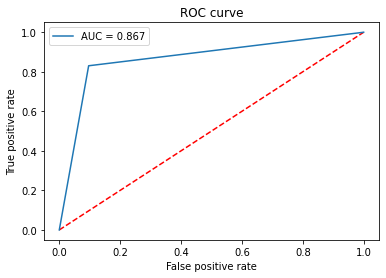

time: 157 ms (started: 2022-01-22 07:34:05 +00:00)


In [92]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(y_true1, y_pred1)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_true1, y_pred1)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

In [ ]:
# pred_class = my_model.predict('/content/drive/My Drive/histopathology/dataset/traintest/40x/2CLASS/test/benign/SOB_B_A-14-22549AB-40-001.png')

In [ ]:
# print('predict class is':pred_class)

In [ ]:
# learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [ ]:
# learn.activation_stats.stats.shape

In [ ]:
# plt.plot(learn.activation_stats.stats[1][-2].numpy());

In [ ]:
# learn.model[0][0]

In [ ]:
# #reference link https://blog.usejournal.com/fastai-image-similarity-search-pytorch-hooks-spotifys-annoy-9161bf517aaf
# class SaveFeatures():
#     features=None
#     def __init__(self, m): 
#         self.hook = m.register_forward_hook(self.hook_fn)
#         self.features = None
#     def hook_fn(self, module, input, output): 
#         out = output.detach().cpu().numpy()
#         if isinstance(self.features, type(None)):
#             self.features = out
#         else:
#             self.features = np.row_stack((self.features, out))
#     def remove(self): 
#         self.hook.remove()

In [ ]:
#features from  0th layer
# sf_conv0 = SaveFeatures(learn.model[0][0])
# sf_conv0
#features from  0th layer
# sf_conv2 = SaveFeatures(learn.model[2][0])
# sf_conv4_0 = SaveFeatures(learn.model[4][0][0])
# sf_conv4_1 = SaveFeatures(learn.model[4][1][0])
# sf_conv4_2 = SaveFeatures(learn.model[4][2][0])
# sf_conv6_0 = SaveFeatures(learn.model[6][0][0])
# sf_conv6_1 = SaveFeatures(learn.model[6][1][0])
# sf_conv6_2 = SaveFeatures(learn.model[6][2][0])
# sf_conv8_0 = SaveFeatures(learn.model[8][0][0])
# sf_conv8_1 = SaveFeatures(learn.model[8][1][0])
# sf_conv8_2 = SaveFeatures(learn.model[8][2][0])
# sf_conv10_0 = SaveFeatures(learn.model[10][0][0])
# sf_conv10_1 = SaveFeatures(learn.model[10][1][0])
# sf_conv10_2 = SaveFeatures(learn.model[10][2][0])
# sf_conv11_0 = SaveFeatures(learn.model[11][0])
# sf_conv12_0 = SaveFeatures(learn.model[12][0])
# sf_conv13_0 = SaveFeatures(learn.model[13][0])

In [ ]:
# plt.plot(learn.activation_stats.stats[1][-2].numpy());

In [ ]:
# # .module because DataParallel was used
# model = learn.model

In [ ]:
# learn.model[15]

In [ ]:
# sf = SaveFeatures(learn.model[15])
# sf

In [ ]:
# _= learn.get_preds(data.train_ds)
# _= learn.get_preds(DatasetType.Valid)

In [ ]:
# len(sf.features)

In [ ]:
# sf.features.shape

In [ ]:
# sf.features[:,0]

In [ ]:
# sf.features[:,1]

In [ ]:
# df_linear = pd.DataFrame({'feature1': sf.features[:,0], 'feature2': sf.features[:,1]})
# df_linear


In [ ]:
# df_conv['feature1'] = pca_2d[:,0]
# df_conv['feature2'] = pca_2d[:,1]
# df_conv

In [ ]:
# df_cat = pd.concat([df_conv, df_conv10],axis=1)
# # df_cat
# df_cat = pd.concat([df_conv4_1, df_conv4_2,df_conv6_0,df_conv6_1],axis=1)
# df_cat

In [ ]:
# from sklearn.decomposition import PCA 
# pca = PCA(n_components=0.99)
# pca_lowerconv = pca.fit_transform(df_cat)
# pca_lowerconv.shape


(2000, 1598)

time: 1min 20s (started: 2021-08-04 06:30:06 +00:00)


In [ ]:
# df_lowerconv= pd.DataFrame(pca_lowerconv)
# df_lowerconv

In [ ]:
# # df_cat.to_csv('feature_lower conv_40x.csv')
# df_linear.to_csv('feature_FC_40x.csv')

In [ ]:
# df_trainfeature= pd.read_csv('feature_FC_40x.csv', index_col = 0)
# from google.colab import files
# files.download('feature_FC_40x.csv')

In [ ]:
# label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
# label_id
# df_label=pd.DataFrame({'label':label_id})
# df_label

In [ ]:
# df_label.to_csv('labelFC_40x.csv')
# from google.colab import files
# files.download('labelFC_40x.csv')

In [ ]:
#  df_trainlabel= pd.read_csv('labelFC_40x.csv', index_col = 0)

In [ ]:
# # Read data
# x= pd.read_csv("feature_FC_40x.csv")
# labels = pd.read_csv("labelFC_40x.csv")

# # Split data to train and test on 90-10 ratio
# # X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size = 0.2, random_state=0)
# from sklearn.model_selection import KFold, StratifiedKFold
# skf = StratifiedKFold(n_splits=5)	# n_Splits stands for number of folds required (2 is the default minimum)
# num_of_splits = 5 	# Specify the number of splits required (to calculate the average MAE)

# skf.get_n_splits(x,labels)
# print(skf) 

In [ ]:
# import numpy as np
# import pandas as pd 
# import sys, os
# import matplotlib.pyplot as plt
# from sklearn import svm
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import f1_score
# x= pd.read_csv("feature_FC_40x.csv")
# labels = pd.read_csv("labelFC_40x.csv")
# for train_index, test_index in skf.split(x,labels): 
#     #Train-test split on data and label 
#     x_train, x_test = x.iloc[train_index], x.iloc[test_index]
#     y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
#     # Plot traning and test data
#     #plot_data(X_train, y_train, X_test, y_test)
#     clf = svm.SVC(kernel='linear')
#     # Train classifier 
#     clf.fit(x_train, y_train)
#     # Plot decision function on training and test data
#     #plot_decision_function(X_train, y_train, X_test, y_test, clf)
#     # Make predictions on unseen test data
#     clf_predictions = clf.predict(x_test)
#     print("Accuracy: {}%".format(clf.score(x_test, y_test) * 100 ))
#     # Create a linear SVM classifier with C = 1   
#     y_true1 = y_test
#     y_pred1 = clf_predictions
#     target_names = ['benign', 'malignant']
#     print(classification_report(y_true1, y_pred1, target_names=target_names))
#     np.set_printoptions(threshold=np.inf) 
#     cm1 = confusion_matrix(y_true1, y_pred1)
#     print(cm1)
#     total1=sum(sum(cm1))
#     sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
#     print('Sensitivity : ', sensitivity1 )
#     specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
#     print('Specificity : ', specificity1)
#     precision = cm1[0,0]/(cm1[0,0]+cm1[1,0])
#     print('precision : ', precision)
#     f1_score(y_true1, y_pred1)


In [ ]:
# import numpy as np
# import pandas as pd 
# import sys, os
# import matplotlib.pyplot as plt
# from sklearn import svm
# from sklearn.model_selection import train_test_split, GridSearchCV


# # Read data
# x= pd.read_csv("feature_train.csv")
# labels = pd.read_csv("label_train.csv")

# # Split data to train and test on 90-10 ratio
# X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size = 0.2, random_state=0)

# # Plot traning and test data
# #plot_data(X_train, y_train, X_test, y_test)
# clf = svm.SVC(kernel='linear')
# # Train classifier 
# clf.fit(X_train, y_train)

# # Plot decision function on training and test data

# #plot_decision_function(X_train, y_train, X_test, y_test, clf)
# # Make predictions on unseen test data
# clf_predictions = clf.predict(X_test)
# print("Accuracy: {}%".format(clf.score(X_test, y_test) * 100 ))
# # Create a linear SVM classifier with C = 1

In [ ]:
# from sklearn.metrics import classification_report
# y_true1 = y_test
# y_pred1 = clf_predictions
# target_names = ['benign', 'malignant']
# print(classification_report(y_true1, y_pred1, target_names=target_names))

In [ ]:
# from sklearn.metrics import confusion_matrix
# np.set_printoptions(threshold=np.inf) 
# cm1 = confusion_matrix(y_true1, y_pred1)
# print(cm1)

In [ ]:
# #Confusion matrix,  sensitivity and specificity
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import f1_score
# total1=sum(sum(cm1))


# sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
# print('Sensitivity : ', sensitivity1 )

# specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
# print('Specificity : ', specificity1)
# precision = cm1[0,0]/(cm1[0,0]+cm1[1,0])
# print('precision : ', precision)
# f1_score(y_true1, y_pred1)


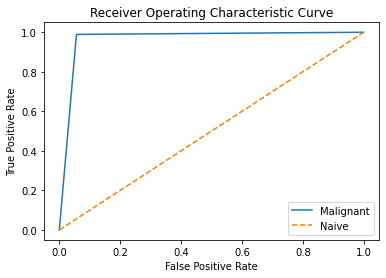

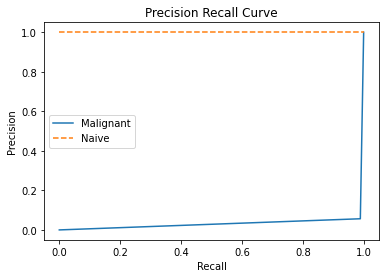

ROC area is 0.9663196480938417
time: 291 ms


In [ ]:
# # learn = load_learner(dataset_dir, test=ImageList.from_folder(test_dir))
# # preds,y = learn.get_preds(ds_type=DatasetType.Test)
# # probs,targets = learn.get_preds(ds_type=DatasetType.Test)
# from sklearn.metrics import roc_curve, auc
# # # probs from log preds
# # probs1 = np.exp(probs[:,1])
# # Compute ROC curve
# fpr, tpr, thresholds = roc_curve(y_true1, y_pred1, pos_label=1)
# import matplotlib.pyplot as plt
# plt.figure()
# plt.plot(fpr, tpr, label="Malignant")
# plt.plot([0,1],[0,1], linestyle='--', label='Naive')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(tpr, fpr, label="Malignant")
# # naive = len(y_pred1[y_pred1==1]) / len(y_pred1)
# naive = len(y_test[y_test==1]) / len(y_test)
# plt.plot([0,1],[naive,naive], linestyle='--', label='Naive')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision Recall Curve')
# plt.legend()
# plt.show()

# # Compute ROC area
# roc_auc = auc(fpr, tpr)
# print('ROC area is {0}'.format(roc_auc))